# Stock Prediction using ARIMA

In [375]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Loading and Handling Time Series in Pandas

In [376]:
tsla = pd.read_csv("TSLA.csv", parse_dates=['Date'], index_col="Date")
tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


These prices reflect two different ways of determining the value of the stock. The closing price is simply the cash value of that specific piece of stock at day's end while the adjusted closing price reflects the closing price of the stock in relation to other stock attributes. In general, the adjusted closing price is considered to be a more technically accurate reflection of the true value of the stock.

For this project we will use Adjusted Close price, so we will drop the Close price and rename the Adjusted Close price as Close price.

In [377]:
tsla = tsla.drop('Close', axis=1)
tsla = tsla.rename(columns={"Adj Close": "Close"})
tsla

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900
...,...,...,...,...,...
2020-07-29,1501.000000,1534.810059,1487.000000,1499.109985,9426900
2020-07-30,1488.000000,1513.239990,1471.000000,1487.489990,7621000
2020-07-31,1515.000000,1517.050049,1420.979980,1430.760010,12247000


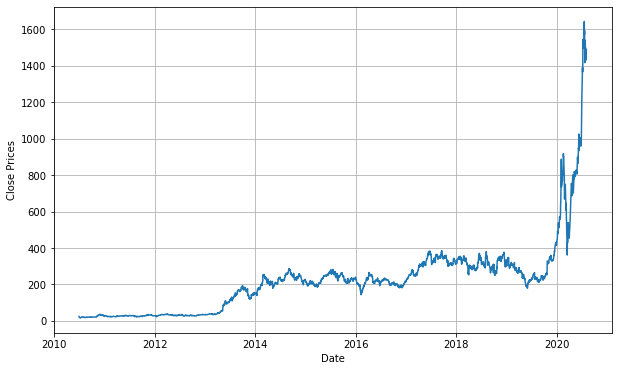

In [356]:
# Visualize the stock’s daily closing price.
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(tsla['Close'])
#plt.title('TESLA closing price')
plt.show()

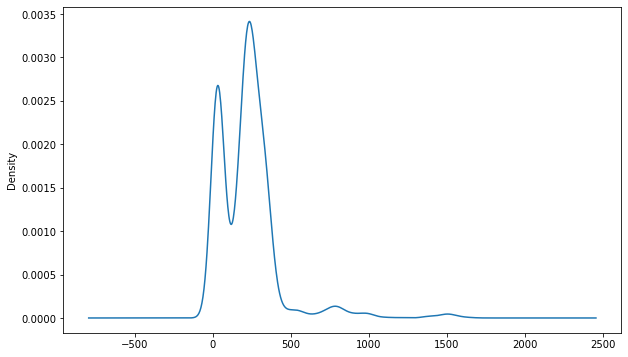

In [378]:
# Probability Distribution of the dataset
tsla_close = tsla['Close']
tsla_close.plot(kind='kde')
plt.show()

### Check Stationary
While working with time series data, it is important to check data stationarity.
We will use the ADF to check the test statistics and critical values values to determine if the dataset is stationary or not.

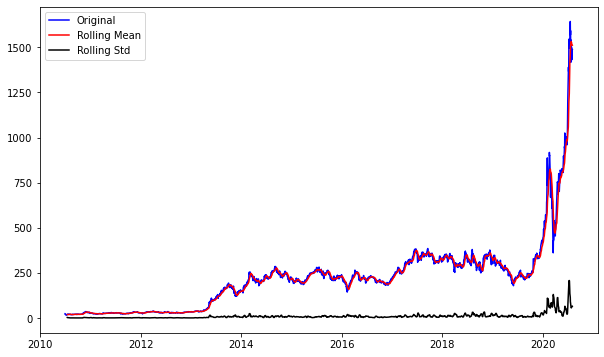

Results of dickey fuller test
Test Statistics                   3.728795
p-value                           1.000000
No. of lags used                 26.000000
Number of observations used    2516.000000
critical value (1%)              -3.432952
critical value (5%)              -2.862689
critical value (10%)             -2.567382
dtype: float64


In [379]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    #plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(tsla['Close'])

Null hypothesis in ADF test is that Data is not stationary.
- if Test Statistic < Critical Values => Rejects the null hypothesis.
- if Test Statistic >Critical Values => failed to reject the null hypothesis.

Based on the results we received from the nest, we can not reject the null hypothesis, so we would need to transform the data.

### Separating seasonality and trend 

<Figure size 720x432 with 0 Axes>

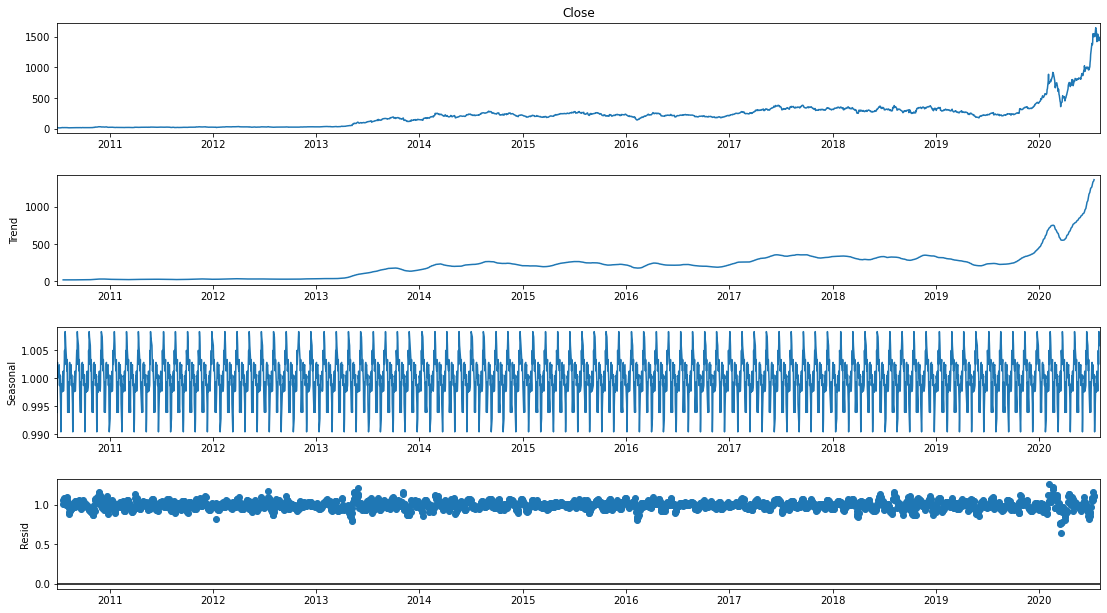

In [380]:
result = seasonal_decompose(tsla['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

### Transformation
We will take the log of the series to apply transformation which will penalize higher values more than smaller values. 

No handles with labels found to put in legend.


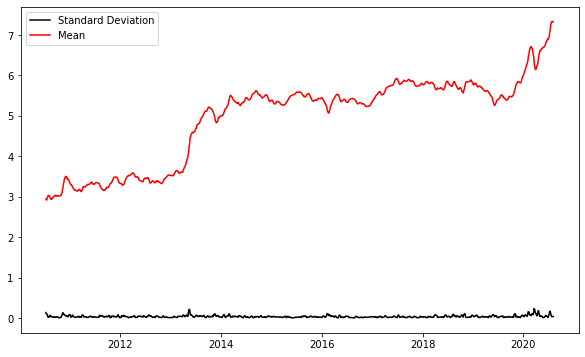

In [383]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
tsla_log = np.log(tsla['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = tsla_log.rolling(12).std()
plt.legend(loc='best')
#plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [385]:
tsla['Close'] = tsla_log

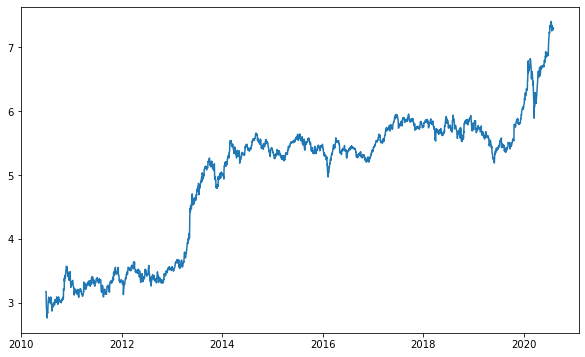

In [386]:
plt.plot(tsla['Close'])

# Feature Engineering
We will use generate some technical indicators so we can perform multivariate analysis by using ARIMAX model.

### Moving Average 

In [387]:
# MA Function
import datetime
import warnings
warnings.filterwarnings('ignore')

def MovingAverage(df, start_date = '1996-01-02', end_date = '2020-08-06', 
                               short_window = 20, long_window = 50, moving_avg = 'SMA'):
    '''
    The function takes the dataset, time-duration of analysis, 
    look-back periods and the moving-average type(SMA or EMA) as input 
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # start_date - (str)start analysis from this date (format: 'YYYY-MM-DD') Eg: '2018-01-01'
    # end_date - (str)end analysis on this date (format: 'YYYY-MM-DD') Eg: '2020-01-01'
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20 
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)
    
    #df['Close'] = df.loc[start_date:end_date,'Close'] # assign new colun name
    df.dropna(axis = 0, inplace = True) # remove any null rows 
    
    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  
  
    if moving_avg == 'SMA':
        # Create a short simple moving average column
        df[short_window_col] = df['Close'].rolling(window = short_window, min_periods = 1).mean()

        # Create a long simple moving average column
        df[long_window_col] = df['Close'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        df[short_window_col] = df['Close'].ewm(span = short_window, adjust = False).mean()

        # Create a long exponential moving average column
        df[long_window_col] = df['Close'].ewm(span = long_window, adjust = False).mean()
MovingAverage(tsla)

### Bollinger Band 

In [388]:
# BB Function
def BollingerBand(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb
tsla['Upper_BB'], tsla['Lower_BB'] = BollingerBand(tsla['Close'], tsla['20_SMA'], 20)
tsla.dropna(inplace=True)
tsla

,Open,High,Low,Close,Volume,20_SMA,50_SMA,Upper_BB,Lower_BB
Date,,,,,,,,,
2010-07-27,20.910000,21.180000,20.260000,3.022861,619700,2.982789,2.982789,3.218296,2.747283
2010-07-28,20.549999,20.900000,20.510000,3.031099,467200,2.975671,2.985090,3.194960,2.756382
2010-07-29,20.770000,20.879999,20.000000,3.013081,616000,2.967778,2.986362,3.168008,2.767548
2010-07-30,20.200001,20.440001,19.549999,2.992728,426900,2.962953,2.986639,3.155359,2.770547
2010-08-02,20.500000,20.969999,20.330000,3.040706,718100,2.967243,2.988892,3.162696,2.771790
...,...,...,...,...,...,...,...,...,...
2020-07-29,1501.000000,1534.810059,1487.000000,7.312627,9426900,7.282498,7.008577,7.466733,7.098262
2020-07-30,1488.000000,1513.239990,1471.000000,7.304845,7621000,7.296702,7.020783,7.433725,7.159680
2020-07-31,1515.000000,1517.050049,1420.979980,7.265961,12247000,7.305137,7.032025,7.406631,7.203643


In [389]:
# drop ‘Open’, ‘Low’, ‘High’, and ‘Volume’ columns 
tsla.drop(['Open', 'High','Low','Volume'], axis=1, inplace=True)

In [390]:
tsla.head()

,Close,20_SMA,50_SMA,Upper_BB,Lower_BB
Date,,,,,
2010-07-27,3.022861,2.982789,2.982789,3.218296,2.747283
2010-07-28,3.031099,2.975671,2.985090,3.194960,2.756382
2010-07-29,3.013081,2.967778,2.986362,3.168008,2.767548
2010-07-30,2.992728,2.962953,2.986639,3.155359,2.770547
2010-08-02,3.040706,2.967243,2.988892,3.162696,2.771790


# Splitting data 

In [393]:
tsla_log =tsla['Close']

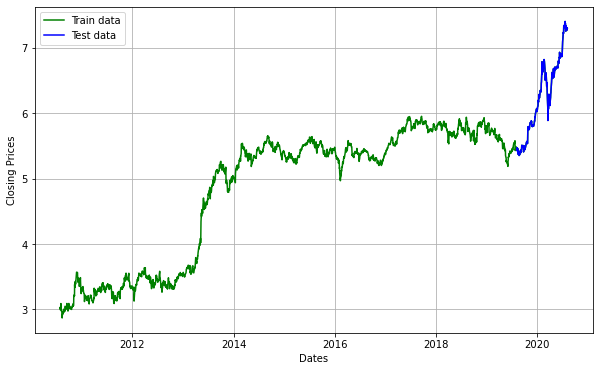

In [394]:
#split data into train and training set
train_data, test_data = tsla_log[3:int(len(tsla_log)*0.9)], tsla_log[int(len(tsla_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(tsla_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

### auto_arima
Instead of observing ACF and PACF plots, we will use the auto_arima function to identify the most optimal parameters for an ARIMA model.

In [395]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9184.012, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9182.531, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9182.552, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9183.380, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9180.541, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.708 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2268
Model:               SARIMAX(0, 1, 0)   Log Likelihood                4594.006
Date:                Thu, 23 Sep 2021   AIC                          -9184.012
Time:                        18:26:04   BIC                          -9172.559
Sample:                             0   HQIC                         -9179.833
                               - 2268                                  

The auto_arima provided the value of p,d, and q as 0,1 and 0 respectively.

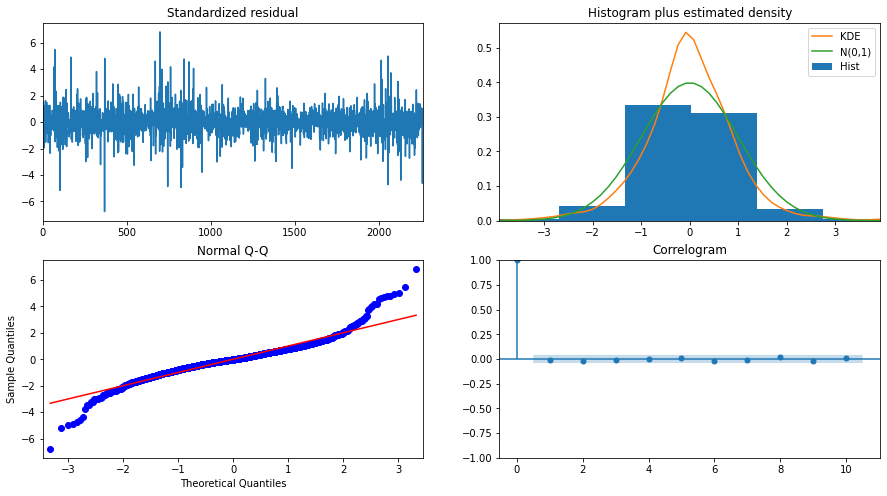

In [397]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# ARIMA Model

In [398]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2267
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4594.006
Method:                           css   S.D. of innovations              0.032
Date:                Thu, 23 Sep 2021   AIC                          -9184.012
Time:                        18:30:28   BIC                          -9172.559
Sample:                             1   HQIC                         -9179.833
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.623      0.105      -0.000       0.002


# Forecasting

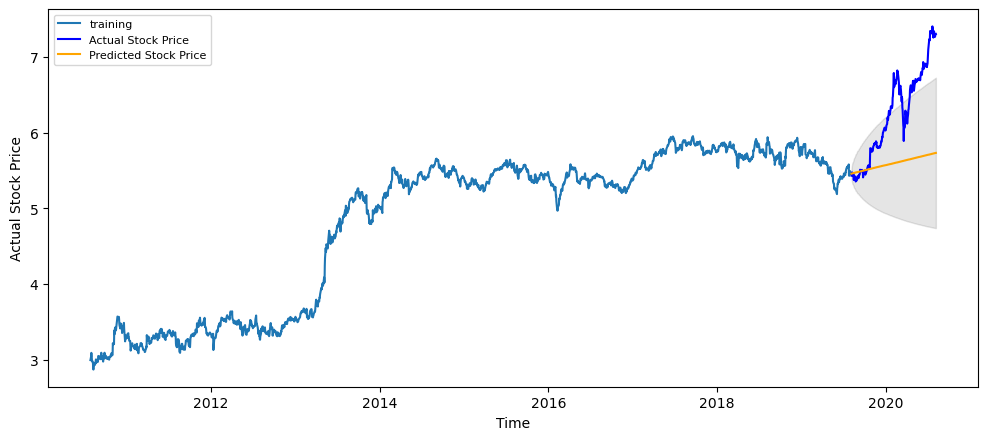

In [400]:
fc, se, conf = fitted.forecast(253, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
#plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [401]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.6857742935340155
MAE: 0.6638883342454152
RMSE: 0.8281149035816319
MAPE: 0.09982834603158602


Around 9.9% MAPE(Mean Absolute Percentage Error) implies the model is about 90.1% accurate in predicting the test set observations.